# Base

In [1]:
import os
import random
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import config
import utils
from model import DependencyBLSTM
loss_list = []
args = config.args
output_dir = args.project_dir + 'Models/' + args.sim_name + '/'

utils.creat_word_embedding()


if not os.path.exists(output_dir):
    os.makedirs(output_dir)
save_path = args.project_dir + 'Models/' + args.sim_name + '/model.pt'

with open(output_dir + 'config', 'w') as config_file:
    argss = (str(args).split('(')[1].split(')')[0].split(','))
    for a in argss:
        config_file.write("{}\n".format(a))
if os.path.exists(save_path):
    model = torch.load(save_path)
    model_loaded = True
    print('Great!!! Pre-Trained Model Loaded !!!')
else:
    model_loaded = False
    print('No pre-trained model ')
    model = DependencyBLSTM(num_words=utils.get_num_words(), max_sen_length=97, max_doc_sent_length=326)

if not os.path.exists(output_dir + 'train_performance_log.csv'):
    train_performance_log = open(output_dir + 'train_performance_log.csv', 'w')
    train_performance_log.write('Step,Loss\n')
else:
    train_performance_log = open(output_dir + 'train_performance_log.csv', 'a')

if not os.path.exists(output_dir + 'eval_performance_log.txt'):
    eval_performance_log = open(output_dir + 'eval_performance_log.txt', 'w')
else:
    eval_performance_log = open(output_dir + 'eval_performance_log.txt', 'a')

if args.gpu > -1:
    model.cuda(device=int(args.gpu))

if not model_loaded:
    if args.fill_embedding:
        embed = utils.get_word_embeddings(source='google')
        with torch.no_grad():
            if args.gpu > -1:
                model.word_embedding.weight.data = torch.FloatTensor(embed).cuda(int(args.gpu))
            else:
                model.word_embedding.weight.data = torch.FloatTensor(embed)
    else:
        with torch.no_grad():
            if args.gpu > -1:
                zeros = np.zeros((utils.get_num_words() + 1, args.word_dim)).astype(float)
                model.word_embedding.weight.data = torch.FloatTensor(zeros).cuda(int(args.gpu))
            else:
                zeros = np.zeros((utils.get_num_words() + 1, args.word_dim)).astype(float)
                model.word_embedding.weight.data = torch.FloatTensor(zeros)

if args.train_embeddings == False:
    model.word_embedding.weight.requires_grad = False

params = [p for p in model.parameters() if p.requires_grad]
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=params, lr=args.lr, weight_decay=args.l2_coeff)
model.zero_grad()
scheduler = StepLR(optimizer, step_size=50, gamma=0.9)
print('Loading sets...')
dev_set = utils.get_split_data(split='dev')
train_set = utils.get_split_data(split='train')
train_set =train_set[0:int(len(train_set))]
print('Train and dev sets loaded')



No pre-trained model 
Loading sets...
Train and dev sets loaded


In [4]:
print(model)

DependencyBLSTM(
  (dropout): Dropout(p=0.0, inplace=False)
  (word_embedding): Embedding(32304, 300)
  (Softmax): Softmax(dim=0)
  (forwardLSTM_sent): LSTM(300, 100, batch_first=True)
  (backwardLSTM_sent): LSTM(300, 100, batch_first=True)
  (sentence_encoder): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.0, inplace=False)
  )
  (parent_encoder_doc): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.0, inplace=False)
  )
  (child_encoder_doc): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.0, inplace=False)
  )
  (root_score_encoder_doc): Linear(in_features=100, out_features=1, bias=True)
  (r_embeds_doc): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2):

In [2]:
def train():
        prev_accuracy = 0
        model.train()
        print('start train')
        global  loss_list
        for step in range(args.step_num + 1):
            random.shuffle(train_set)
            docs = train_set[0:args.batch_size]
            labels = Variable(torch.LongTensor([d['label'] for d in docs]))
            doc_encodings, _ = model(docs)
            optimizer.zero_grad()
            outputs = doc_encodings.cpu()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_list.append(loss.item())
            print("Step {} Loss {}".format(step, loss.detach()))
            train_performance_log.write("{},{}\n".format(step, loss.item()))
            if step % 20 == 0 and step:
                accuracy = evaluation(step)
                if accuracy >= prev_accuracy:
                    torch.save(model, save_path)
                    print("Best model saved in {} Accuracy {}".format(save_path, accuracy))
                    prev_accuracy = accuracy

def evaluation(step):
        print('Start evaluation ...')
        model.eval()
        eval_labels = [d['label'] for d in dev_set]
        labels = Variable(torch.LongTensor(eval_labels))
        doc_encodings, _ = model(dev_set)
        outputs = doc_encodings.cpu()
        loss = criterion(outputs, labels).detach()
        _, predictions = torch.max(outputs.data, 1)
        predictions = predictions.numpy()

        accuracy = accuracy_score(y_true=np.array(eval_labels), y_pred=predictions)
        report = classification_report(y_true=np.array(eval_labels), y_pred=predictions, target_names=['Real', 'Fake'])
        conf_matrix = confusion_matrix(y_true=np.array(eval_labels), y_pred=predictions)
        eval_performance_log.write("Step {}, Loss {} Accuracy {} \n".format(step, loss, accuracy))
        eval_performance_log.write("{}\n".format(report))
        eval_performance_log.write("{}\n".format(conf_matrix))
        eval_performance_log.write("{}\n".format('=' * 50))

        print('************* Evaluation ****************')
        print("Step {}, Loss {}  Accuracy {} ".format(step, loss, accuracy))
        print(report)
        print(conf_matrix)
        print('*****************************************')
        return accuracy

train()


start train
Step 0 Loss 0.6951876878738403
Step 1 Loss 0.9113820791244507
Step 2 Loss 0.6918445229530334
Step 3 Loss 0.6890608668327332
Step 4 Loss 0.7089278101921082
Step 5 Loss 0.6904834508895874
Step 6 Loss 0.6807574033737183
Step 7 Loss 0.6764025688171387
Step 8 Loss 0.6755706071853638
Step 9 Loss 0.6631251573562622
Step 10 Loss 0.6789920926094055
Step 11 Loss 0.6420390605926514
Step 12 Loss 0.5705659985542297
Step 13 Loss 0.694180965423584
Step 14 Loss 0.6865039467811584
Step 15 Loss 0.6255745887756348
Step 16 Loss 0.5787380933761597
Step 17 Loss 0.6266488432884216
Step 18 Loss 0.6147935390472412
Step 19 Loss 0.6154044270515442
Step 20 Loss 0.5637141466140747
Start evaluation ...
************* Evaluation ****************
Step 20, Loss 0.7135787606239319  Accuracy 0.6343283582089553 
              precision    recall  f1-score   support

        Real       0.60      0.78      0.68        67
        Fake       0.69      0.49      0.57        67

    accuracy                         

C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DependencyBLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Softmax. It won't be checked for correctness upon loading.
  "type " + obj.__

Step 21 Loss 0.6571933627128601
Step 22 Loss 0.6862295866012573
Step 23 Loss 0.6782392263412476
Step 24 Loss 0.4856250286102295
Step 25 Loss 0.5110577344894409
Step 26 Loss 0.7394477128982544
Step 27 Loss 0.5376548767089844
Step 28 Loss 0.486133337020874
Step 29 Loss 0.4985828399658203
Step 30 Loss 0.493563711643219
Step 31 Loss 0.5469346642494202
Step 32 Loss 0.522171139717102
Step 33 Loss 0.4776005744934082
Step 34 Loss 0.49304062128067017
Step 35 Loss 0.4055388569831848
Step 36 Loss 0.7171918153762817
Step 37 Loss 0.5124538540840149
Step 38 Loss 0.48316484689712524
Step 39 Loss 0.5220779180526733
Step 40 Loss 0.4610763192176819
Start evaluation ...
************* Evaluation ****************
Step 40, Loss 0.5780075788497925  Accuracy 0.7238805970149254 
              precision    recall  f1-score   support

        Real       0.71      0.76      0.73        67
        Fake       0.74      0.69      0.71        67

    accuracy                           0.72       134
   macro avg     

C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DependencyBLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Softmax. It won't be checked for correctness upon loading.
  "type " + obj.__

Best model saved in D:\prolen\HDSF\Models/sim1/model.pt Accuracy 0.7238805970149254
Step 41 Loss 0.48394685983657837
Step 42 Loss 0.45595628023147583
Step 43 Loss 0.47557124495506287
Step 44 Loss 0.4028434157371521
Step 45 Loss 0.5715954303741455
Step 46 Loss 0.4282892644405365
Step 47 Loss 0.4696780741214752
Step 48 Loss 0.5975123643875122
Step 49 Loss 0.47430700063705444
Step 50 Loss 0.3663634657859802
Step 51 Loss 0.39530161023139954
Step 52 Loss 0.45198479294776917
Step 53 Loss 0.42246752977371216
Step 54 Loss 0.5112836956977844
Step 55 Loss 0.39904460310935974
Step 56 Loss 0.5396987199783325
Step 57 Loss 0.36577317118644714
Step 58 Loss 0.7951493263244629
Step 59 Loss 0.5629233717918396
Step 60 Loss 0.4480525851249695
Start evaluation ...
************* Evaluation ****************
Step 60, Loss 0.5340654850006104  Accuracy 0.746268656716418 
              precision    recall  f1-score   support

        Real       0.80      0.66      0.72        67
        Fake       0.71      0.84

C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DependencyBLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Softmax. It won't be checked for correctness upon loading.
  "type " + obj.__

Best model saved in D:\prolen\HDSF\Models/sim1/model.pt Accuracy 0.746268656716418
Step 61 Loss 0.34855425357818604
Step 62 Loss 0.49650660157203674
Step 63 Loss 0.40732258558273315
Step 64 Loss 0.3362220525741577
Step 65 Loss 0.38056057691574097
Step 66 Loss 0.42147430777549744
Step 67 Loss 0.4327426850795746
Step 68 Loss 0.3764213025569916
Step 69 Loss 0.40295878052711487
Step 70 Loss 0.42769065499305725
Step 71 Loss 0.37788355350494385
Step 72 Loss 0.5378705263137817
Step 73 Loss 0.46464434266090393
Step 74 Loss 0.5036367177963257
Step 75 Loss 0.38895124197006226
Step 76 Loss 0.41789573431015015
Step 77 Loss 0.26993244886398315
Step 78 Loss 0.7751632928848267
Step 79 Loss 0.31830400228500366
Step 80 Loss 0.2593408524990082
Start evaluation ...
************* Evaluation ****************
Step 80, Loss 0.5077610015869141  Accuracy 0.7313432835820896 
              precision    recall  f1-score   support

        Real       0.76      0.67      0.71        67
        Fake       0.71      

KeyboardInterrupt: 

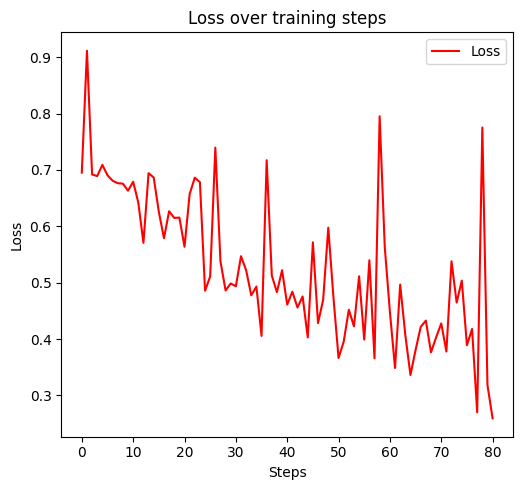

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 2)
plt.plot(range(len(loss_list)), loss_list, label='Loss', color='red')
plt.title('Loss over training steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Optimisation

In [1]:
import os
import random
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import config
import utils
from model import DependencyBLSTM
loss_list = []
args = config.args
output_dir = args.project_dir + 'Models/' + args.sim_name + '/'

utils.creat_word_embedding()


if not os.path.exists(output_dir):
    os.makedirs(output_dir)
save_path = args.project_dir + 'Models/' + args.sim_name + '/model.pt'

with open(output_dir + 'config', 'w') as config_file:
    argss = (str(args).split('(')[1].split(')')[0].split(','))
    for a in argss:
        config_file.write("{}\n".format(a))
if os.path.exists(save_path):
    model = torch.load(save_path)
    model_loaded = True
    print('Great!!! Pre-Trained Model Loaded !!!')
else:
    model_loaded = False
    print('No pre-trained model ')
    model = DependencyBLSTM(num_words=utils.get_num_words(), max_sen_length=97, max_doc_sent_length=326)

if not os.path.exists(output_dir + 'train_performance_log.csv'):
    train_performance_log = open(output_dir + 'train_performance_log.csv', 'w')
    train_performance_log.write('Step,Loss\n')
else:
    train_performance_log = open(output_dir + 'train_performance_log.csv', 'a')

if not os.path.exists(output_dir + 'eval_performance_log.txt'):
    eval_performance_log = open(output_dir + 'eval_performance_log.txt', 'w')
else:
    eval_performance_log = open(output_dir + 'eval_performance_log.txt', 'a')

if args.gpu > -1:
    model.cuda(device=int(args.gpu))

if not model_loaded:
    if args.fill_embedding:
        embed = utils.get_word_embeddings(source='google')
        with torch.no_grad():
            if args.gpu > -1:
                model.word_embedding.weight.data = torch.FloatTensor(embed).cuda(int(args.gpu))
            else:
                model.word_embedding.weight.data = torch.FloatTensor(embed)
    else:
        with torch.no_grad():
            if args.gpu > -1:
                zeros = np.zeros((utils.get_num_words() + 1, args.word_dim)).astype(float)
                model.word_embedding.weight.data = torch.FloatTensor(zeros).cuda(int(args.gpu))
            else:
                zeros = np.zeros((utils.get_num_words() + 1, args.word_dim)).astype(float)
                model.word_embedding.weight.data = torch.FloatTensor(zeros)

if args.train_embeddings == False:
    model.word_embedding.weight.requires_grad = False

params = [p for p in model.parameters() if p.requires_grad]
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=params, lr=args.lr, weight_decay=args.l2_coeff)
model.zero_grad()
scheduler = StepLR(optimizer, step_size=50, gamma=0.9)
print('Loading sets...')
dev_set = utils.get_split_data(split='dev')
train_set = utils.get_split_data(split='train')
train_set =train_set[0:int(len(train_set))]
print('Train and dev sets loaded')

No pre-trained model 
Loading sets...


C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\nn\modules\rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Train and dev sets loaded


In [2]:
print(model)

DependencyBLSTM(
  (dropout): Dropout(p=0.3, inplace=False)
  (word_embedding): Embedding(32304, 300)
  (Softmax): Softmax(dim=0)
  (forwardLSTM_sent): LSTM(300, 120, batch_first=True, dropout=0.3)
  (backwardLSTM_sent): LSTM(300, 120, batch_first=True, dropout=0.3)
  (sentence_encoder): Sequential(
    (0): Linear(in_features=300, out_features=120, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
  )
  (parent_encoder_doc): Sequential(
    (0): Linear(in_features=120, out_features=120, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
  )
  (child_encoder_doc): Sequential(
    (0): Linear(in_features=120, out_features=120, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
  )
  (root_score_encoder_doc): Linear(in_features=120, out_features=1, bias=True)
  (r_embeds_doc): Sequential(
    (0): Linear(in_features=360, out_features=120, bias=True)
    (1): LeakyReLU(neg

In [3]:
def train():
        prev_accuracy = 0
        model.train()
        print('start train')
        global  loss_list
        for step in range(args.step_num + 1):
            random.shuffle(train_set)
            docs = train_set[0:args.batch_size]
            labels = Variable(torch.LongTensor([d['label'] for d in docs]))
            doc_encodings, _ = model(docs)
            optimizer.zero_grad()
            outputs = doc_encodings.cpu()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_list.append(loss.item())
            print("Step {} Loss {}".format(step, loss.detach()))
            train_performance_log.write("{},{}\n".format(step, loss.item()))
            if step % 20 == 0 and step:
                accuracy = evaluation(step)
                if accuracy >= prev_accuracy:
                    torch.save(model, save_path)
                    print("Best model saved in {} Accuracy {}".format(save_path, accuracy))
                    prev_accuracy = accuracy

def evaluation(step):
        print('Start evaluation ...')
        model.eval()
        eval_labels = [d['label'] for d in dev_set]
        labels = Variable(torch.LongTensor(eval_labels))
        doc_encodings, _ = model(dev_set)
        outputs = doc_encodings.cpu()
        loss = criterion(outputs, labels).detach()
        _, predictions = torch.max(outputs.data, 1)
        predictions = predictions.numpy()

        accuracy = accuracy_score(y_true=np.array(eval_labels), y_pred=predictions)
        report = classification_report(y_true=np.array(eval_labels), y_pred=predictions, target_names=['Real', 'Fake'])
        conf_matrix = confusion_matrix(y_true=np.array(eval_labels), y_pred=predictions)
        eval_performance_log.write("Step {}, Loss {} Accuracy {} \n".format(step, loss, accuracy))
        eval_performance_log.write("{}\n".format(report))
        eval_performance_log.write("{}\n".format(conf_matrix))
        eval_performance_log.write("{}\n".format('=' * 50))

        print('************* Evaluation ****************')
        print("Step {}, Loss {}  Accuracy {} ".format(step, loss, accuracy))
        print(report)
        print(conf_matrix)
        print('*****************************************')
        return accuracy

train()


start train
Step 0 Loss 0.694191038608551
Step 1 Loss 0.6909263134002686
Step 2 Loss 1.278325080871582
Step 3 Loss 0.6763399243354797
Step 4 Loss 0.6904548406600952
Step 5 Loss 0.655903160572052
Step 6 Loss 0.6468519568443298
Step 7 Loss 0.7065135836601257
Step 8 Loss 0.6591670513153076
Step 9 Loss 0.6633109450340271
Step 10 Loss 0.7028975486755371
Step 11 Loss 0.6950920820236206
Step 12 Loss 0.6692622303962708
Step 13 Loss 0.6675935387611389
Step 14 Loss 0.6794126033782959
Step 15 Loss 0.6533548831939697
Step 16 Loss 0.6337531208992004
Step 17 Loss 0.6371766924858093
Step 18 Loss 0.5659450888633728
Step 19 Loss 0.5392814874649048
Step 20 Loss 0.5938372611999512
Start evaluation ...
************* Evaluation ****************
Step 20, Loss 0.6522945761680603  Accuracy 0.6417910447761194 
              precision    recall  f1-score   support

        Real       0.65      0.63      0.64        67
        Fake       0.64      0.66      0.65        67

    accuracy                           

C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DependencyBLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Softmax. It won't be checked for correctness upon loading.
  "type " + obj.__

Best model saved in D:\prolen\HDSF\Models/sim1/model.pt Accuracy 0.6417910447761194
Step 21 Loss 0.555043637752533
Step 22 Loss 0.5777326822280884
Step 23 Loss 0.6528508067131042
Step 24 Loss 0.48579543828964233
Step 25 Loss 0.6291092038154602
Step 26 Loss 0.7168712615966797
Step 27 Loss 0.35638007521629333
Step 28 Loss 0.48860225081443787
Step 29 Loss 0.5570846796035767
Step 30 Loss 0.6306418776512146
Step 31 Loss 0.33875012397766113
Step 32 Loss 0.4821772873401642
Step 33 Loss 0.3464428186416626
Step 34 Loss 0.5629082322120667
Step 35 Loss 0.5192880630493164
Step 36 Loss 0.46451660990715027
Step 37 Loss 0.5852728486061096
Step 38 Loss 0.5137929320335388
Step 39 Loss 0.49280908703804016
Step 40 Loss 0.9581992030143738
Start evaluation ...
************* Evaluation ****************
Step 40, Loss 0.791272759437561  Accuracy 0.6791044776119403 
              precision    recall  f1-score   support

        Real       0.64      0.81      0.72        67
        Fake       0.74      0.55    

C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DependencyBLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Softmax. It won't be checked for correctness upon loading.
  "type " + obj.__

Step 41 Loss 0.9228911995887756
Step 42 Loss 0.5632766485214233
Step 43 Loss 0.46785712242126465
Step 44 Loss 0.5499942302703857
Step 45 Loss 0.7901045083999634
Step 46 Loss 0.5867999196052551
Step 47 Loss 0.6631081700325012
Step 48 Loss 0.561596155166626
Step 49 Loss 0.5850295424461365
Step 50 Loss 0.555812418460846
Step 51 Loss 0.5813959240913391
Step 52 Loss 0.5707417130470276
Step 53 Loss 0.6027571558952332
Step 54 Loss 0.6302050948143005
Step 55 Loss 0.4944385290145874
Step 56 Loss 0.6808716058731079
Step 57 Loss 0.5629943609237671
Step 58 Loss 0.5230717658996582
Step 59 Loss 0.4940260350704193
Step 60 Loss 0.5042124390602112
Start evaluation ...
************* Evaluation ****************
Step 60, Loss 0.5585436224937439  Accuracy 0.746268656716418 
              precision    recall  f1-score   support

        Real       0.80      0.66      0.72        67
        Fake       0.71      0.84      0.77        67

    accuracy                           0.75       134
   macro avg      

C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DependencyBLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Softmax. It won't be checked for correctness upon loading.
  "type " + obj.__

Best model saved in D:\prolen\HDSF\Models/sim1/model.pt Accuracy 0.746268656716418
Step 61 Loss 0.5300112962722778
Step 62 Loss 0.4392034113407135
Step 63 Loss 0.5979667901992798
Step 64 Loss 0.5221068263053894
Step 65 Loss 0.4416736364364624
Step 66 Loss 0.3732570707798004
Step 67 Loss 0.459595650434494
Step 68 Loss 0.4620856046676636
Step 69 Loss 0.5672538876533508
Step 70 Loss 0.35180285573005676
Step 71 Loss 0.4471902847290039
Step 72 Loss 0.4283324182033539
Step 73 Loss 0.36247697472572327
Step 74 Loss 0.5793747901916504
Step 75 Loss 0.3685426712036133
Step 76 Loss 0.5730700492858887
Step 77 Loss 0.48702332377433777
Step 78 Loss 0.5535509586334229
Step 79 Loss 0.35020411014556885
Step 80 Loss 0.5408914685249329
Start evaluation ...
************* Evaluation ****************
Step 80, Loss 0.5088578462600708  Accuracy 0.7761194029850746 
              precision    recall  f1-score   support

        Real       0.78      0.76      0.77        67
        Fake       0.77      0.79      

C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DependencyBLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\rkris\.conda\envs\prolen\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Softmax. It won't be checked for correctness upon loading.
  "type " + obj.__

Best model saved in D:\prolen\HDSF\Models/sim1/model.pt Accuracy 0.7761194029850746


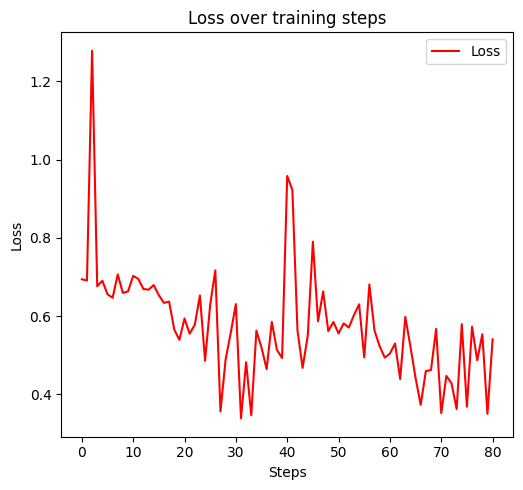

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 2)
plt.plot(range(len(loss_list)), loss_list, label='Loss', color='red')
plt.title('Loss over training steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()